<a href="https://colab.research.google.com/github/benitomartin/multimodal-llm-pymupdf4llm/blob/main/Multimodal_PyMuPDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq pymupdf4llm
!pip install -qq llama-index
!pip install -qq llama-index qdrant-client
!pip install -qq llama-index-vector-stores-qdrant
!pip install -qq git+https://github.com/openai/CLIP.git
!pip install -qq llama-index-embeddings-clip

  Preparing metadata (setup.py) ... done


In [ ]:
import os
from google.colab import userdata
import pymupdf4llm

import qdrant_client
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance

from llama_index.core import Document, SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import ImageDocument, ImageNode
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.response.notebook_utils import display_source_node

import json

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

You can download the document used in this notebook [here](https://arxiv.org/abs/1706.03762)

In [ ]:
# Perform the markdown conversion
docs = pymupdf4llm.to_markdown(doc="/content/document.pdf",
                                  page_chunks = True,
                                  write_images = True,
                                  image_path = "/content/images",
                                  image_format = "jpg",
                                  )

Processing /content/document.pdf...
[                                        ] (0/15)==[==                                      ] ( 1/15)===[=====                                   ] ( 2/15)==[========                                ] ( 3/15)===[==========                              ] ( 4/15)===[=============                           ] ( 5/15)==[================                        ] ( 6/15)===

In [ ]:
llama_documents = []

for document in docs:
    # Extract just the 'metadata' field and convert certain elements as needed
    metadata = {
        "file_path": document["metadata"].get("file_path"),
        "page": str(document["metadata"].get("page")),
        "images": str(document.get("images")),
        "toc_items": str(document.get("toc_items")),

    }

    # Create a Document object with just the text and the cleaned metadata
    llama_document = Document(
        text=document["text"],
        metadata=metadata,
        text_template="Metadata: {metadata_str}\n-----\nContent: {content}",
    )

    llama_documents.append(llama_document)

In [ ]:
llama_documents[0]

Document(id_='2e043b1d-cdc4-47b1-81df-278c852dc534', embedding=None, metadata={'file_path': '/content/document.pdf', 'page': '1', 'images': '[]', 'toc_items': '[]'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='#### Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\n\n## Attention Is All You Need\n\n\n**Ashish Vaswani[∗]**\nGoogle Brain\n```\navaswani@google.com\n\n```\n**Llion Jones[∗]**\nGoogle Research\n```\n llion@google.com\n\n```\n\n**Noam Shazeer[∗]**\nGoogle Brain\n```\nnoam@google.com\n\n```\n\n**Aidan N. Gomez[∗†]**\nUniversity of Toronto\n```\naidan@cs.toronto.edu\n\n```\n\n**Niki Parmar[∗]**\nGoogle Research\n```\nnikip@google.com\n\n```\n\n**Jakob Uszkoreit[∗]**\nGoogle Research\n```\nusz@google.com\n\n```\n\n**Łukasz Kaiser[∗]**\nGoogle Brain\n```\nlukaszkaiser@google.com\n\n```\n\n**Illia Polosukhin[∗‡]**\n

In [ ]:
client = qdrant_client.QdrantClient(location=":memory:")

In [ ]:
# Create a collection for text data
client.create_collection(
    collection_name="text_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE)
)

# Create a collection for image data
client.create_collection(
    collection_name="image_collection",
    vectors_config=VectorParams(size=512, distance=Distance.COSINE)
)

True

In [ ]:
# Initialize Collections
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)

image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

In [ ]:
# Create the MultiModal index

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# context images
image_path = "/content/images"
image_documents = SimpleDirectoryReader(image_path).load_data()

index = MultiModalVectorStoreIndex.from_documents(
    llama_documents + image_documents,
    storage_context=storage_context)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 133MiB/s]


In [ ]:
# Set query and retriever
query = "Could you provide an image of the Multi-Head Attention?"

retriever = index.as_retriever(similarity_top_k=1, image_similarity_top_k=1)  # Adjust to retrieve enough images

retrieval_results = retriever.retrieve(query)

In [ ]:
retrieval_results

[NodeWithScore(node=TextNode(id_='70f127a0-5a71-4d31-abbe-b387efe87004', embedding=None, metadata={'file_path': '/content/document.pdf', 'page': '5', 'images': '[]', 'toc_items': "[[3, 'Applications of Attention in our Model', 5], [2, 'Position-wise Feed-Forward Networks', 5], [2, 'Embeddings and Softmax', 5]]"}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1cef4562-f63b-4210-a5a1-9cfb73c243bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/content/document.pdf', 'page': '5', 'images': '[]', 'toc_items': "[[3, 'Applications of Attention in our Model', 5], [2, 'Position-wise Feed-Forward Networks', 5], [2, 'Embeddings and Softmax', 5]]"}, hash='0f2ad0b590aa7f8bb81d763dae8e2d648e6530216a1c9e5b913656abeb4f9fe3')}, text='output values. These are concatenated and once again projected, resulting in the final values, as\ndepicted in Figure 2.\n\nMulti-head attention allows the model to 

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_path)

<Figure size 1600x900 with 0 Axes>

Highest Scored TextNode
-----------------------


**Node ID:** 70f127a0-5a71-4d31-abbe-b387efe87004<br>**Similarity:** 0.8199309663422424<br>**Text:** output values. These are concatenated and once again projected, resulting in the final values, as
depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from ...<br>

Highest Scored ImageNode
-----------------------


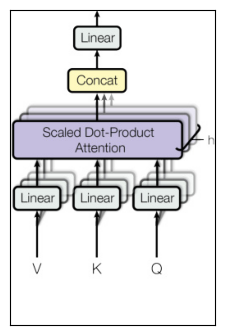

In [ ]:
retrieved_image = []

for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        print("Highest Scored ImageNode")
        print("-----------------------")
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        print("Highest Scored TextNode")
        print("-----------------------")

        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)